# Projeto 17: Compactação de imagens com Deep Autoencoders

In [1]:
!pip install torch==1.4.0 torchvision==0.5.0

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 44.4MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


## Etapa 1: Importação das bibliotecas

In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(123)

## Etapa 2: Base de dados

In [4]:
data_train = datasets.MNIST('MNIST-data', train = True, download=True,
                               transform = transforms.ToTensor())
loader_train = torch.utils.data.DataLoader(data_train, batch_size=256,
                                           shuffle = True)

Extracting MNIST-data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST-data/MNIST/raw


Extracting MNIST-data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST-data/MNIST/raw


Extracting MNIST-data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST-data/MNIST/raw




Extracting MNIST-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST-data/MNIST/raw
Processing...
Done!


In [5]:
data_test = datasets.MNIST('MNIST-data', train = False, download=True,
                           transform = transforms.ToTensor())
loader_test = torch.utils.data.DataLoader(data_test, batch_size=256,
                                          shuffle=True)

## Etapa 3: Construção do autoencoder

In [6]:
# 784 -> 128 -> 64 -> 32 -> 64 -> 128 -> 784
class autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    # CAMADA DO ENCODER
    self.encoder0 = nn.Linear(in_features=784, out_features=128)
    self.encoder1 = nn.Linear(128,64)
    self.encoder2 = nn.Linear(64,32)

    # CAMADA DO DECODER
    self.decoder0 = nn.Linear(32,64)
    self.decoder1 = nn.Linear(64,128)
    self.decoder2 = nn.Linear(128,784)

    # CAMADAS DE ATIVAÇÃO
    self.activation0 = nn.ReLU()
    self.activation1 = nn.Sigmoid()

  def forward(self, X):
    # ESTRUTURA DO ENCODER    
    X = self.activation0(self.encoder0(X))
    X = self.activation0(self.encoder1(X))
    X = self.activation0(self.encoder2(X))

    # ESTRUTURA DO DECODER
    X = self.activation0(self.decoder0(X))
    X = self.activation0(self.decoder1(X))
    X = self.activation1(self.decoder2(X))
    return X

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [8]:
model = autoencoder()
model.to(device)

autoencoder(
  (encoder0): Linear(in_features=784, out_features=128, bias=True)
  (encoder1): Linear(in_features=128, out_features=64, bias=True)
  (encoder2): Linear(in_features=64, out_features=32, bias=True)
  (decoder0): Linear(in_features=32, out_features=64, bias=True)
  (decoder1): Linear(in_features=64, out_features=128, bias=True)
  (decoder2): Linear(in_features=128, out_features=784, bias=True)
  (activation0): ReLU()
  (activation1): Sigmoid()
)

In [9]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

## Etapa 4: Treinamento do modelo

In [10]:
for epoch in range(50):
  # TREINAMENTO
  running_loss_train = 0.
  for data in loader_train:
    model.train()
    inputs, _ = data
    inputs = inputs.to(device)
    inputs = inputs.view(-1, 28*28)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, inputs.view(*outputs.shape))
    loss.backward()

    optimizer.step()

    running_loss_train += loss.item()

  # VALIDAÇÃO
  running_loss_val = 0.
  for data in loader_test:
    model.eval()
    inputs, _ = data
    inputs = inputs.to(device)
    inputs = inputs.view(-1,28*28)
    
    outputs = model(inputs)
    loss = criterion(outputs, inputs.view(*outputs.shape))
    running_loss_val += loss.item()

  print('ÉPOCA {:3d}: PERDA TREINO {:.5f} PERDA VALIDAÇÃO {:.5f}' \
        .format(epoch+1, running_loss_train/len(loader_train), running_loss_val/len(loader_test)))

ÉPOCA   1: PERDA TREINO 0.29591 PERDA VALIDAÇÃO 0.23410
ÉPOCA   2: PERDA TREINO 0.21089 PERDA VALIDAÇÃO 0.18304
ÉPOCA   3: PERDA TREINO 0.16522 PERDA VALIDAÇÃO 0.15275
ÉPOCA   4: PERDA TREINO 0.14859 PERDA VALIDAÇÃO 0.14325
ÉPOCA   5: PERDA TREINO 0.14161 PERDA VALIDAÇÃO 0.13721
ÉPOCA   6: PERDA TREINO 0.13651 PERDA VALIDAÇÃO 0.13312
ÉPOCA   7: PERDA TREINO 0.13225 PERDA VALIDAÇÃO 0.12899
ÉPOCA   8: PERDA TREINO 0.12865 PERDA VALIDAÇÃO 0.12500
ÉPOCA   9: PERDA TREINO 0.12524 PERDA VALIDAÇÃO 0.12257
ÉPOCA  10: PERDA TREINO 0.12226 PERDA VALIDAÇÃO 0.11961
ÉPOCA  11: PERDA TREINO 0.11975 PERDA VALIDAÇÃO 0.11692
ÉPOCA  12: PERDA TREINO 0.11760 PERDA VALIDAÇÃO 0.11542
ÉPOCA  13: PERDA TREINO 0.11579 PERDA VALIDAÇÃO 0.11372
ÉPOCA  14: PERDA TREINO 0.11417 PERDA VALIDAÇÃO 0.11240
ÉPOCA  15: PERDA TREINO 0.11274 PERDA VALIDAÇÃO 0.11065
ÉPOCA  16: PERDA TREINO 0.11142 PERDA VALIDAÇÃO 0.10962
ÉPOCA  17: PERDA TREINO 0.11028 PERDA VALIDAÇÃO 0.10925
ÉPOCA  18: PERDA TREINO 0.10923 PERDA VALIDAÇÃO 

## Etapa 5: Geração do encoder

In [11]:
list(model.children())

[Linear(in_features=784, out_features=128, bias=True),
 Linear(in_features=128, out_features=64, bias=True),
 Linear(in_features=64, out_features=32, bias=True),
 Linear(in_features=32, out_features=64, bias=True),
 Linear(in_features=64, out_features=128, bias=True),
 Linear(in_features=128, out_features=784, bias=True),
 ReLU(),
 Sigmoid()]

In [20]:
class encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder0 = list(model.children())[0]     # Linear => 784 -> 128
    self.encoder1 = list(model.children())[1]     # Linear => 128 -> 64
    self.encoder2 = list(model.children())[2]     # Linear => 64 -> 32
    self.activation0 = list(model.children())[6]  # RELU

  def forward(self, X):
    X = self.activation0(self.encoder0(X))
    X = self.activation0(self.encoder1(X))
    X = self.activation0(self.encoder2(X))
    return X

In [21]:
model_enc = encoder()
model_enc.to(device)

encoder(
  (encoder0): Linear(in_features=784, out_features=128, bias=True)
  (encoder1): Linear(in_features=128, out_features=64, bias=True)
  (encoder2): Linear(in_features=64, out_features=32, bias=True)
  (activation0): ReLU()
)

## Etapa 6: Geração do decoder

In [22]:
list(model.children())

[Linear(in_features=784, out_features=128, bias=True),
 Linear(in_features=128, out_features=64, bias=True),
 Linear(in_features=64, out_features=32, bias=True),
 Linear(in_features=32, out_features=64, bias=True),
 Linear(in_features=64, out_features=128, bias=True),
 Linear(in_features=128, out_features=784, bias=True),
 ReLU(),
 Sigmoid()]

In [23]:
class decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.decoder0 = list(model.children())[3]       # Linear => 32 -> 64
    self.decoder1 = list(model.children())[4]       # Linear => 64 -> 128
    self.decoder2 = list(model.children())[5]       # Linear => 128 -> 784
    self.activation0 = list(model.children())[6]    # Relu
    self.activation1 = list(model.children())[7]    # Sigmoid

  def forward(self, X):
    X = self.activation0(self.decoder0(X))
    X = self.activation0(self.decoder1(X))
    X = self.activation1(self.decoder2(X))
    return X

In [24]:
model_dec = decoder()
model_dec.to(device)

decoder(
  (decoder0): Linear(in_features=32, out_features=64, bias=True)
  (decoder1): Linear(in_features=64, out_features=128, bias=True)
  (decoder2): Linear(in_features=128, out_features=784, bias=True)
  (activation0): ReLU()
  (activation1): Sigmoid()
)

## Etapa 7: Visualização dos resultados

In [25]:
num_images = 10
img_test = next(iter(loader_test))[0][:num_images]
img_test = img_test.to(device)
img_test = img_test.view(-1, 28*28)

In [26]:
img_test.shape

torch.Size([10, 784])

In [27]:
model_enc.eval()
img_cod = model_enc(img_test)

In [28]:
img_cod.shape

torch.Size([10, 32])

In [29]:
model_dec.eval()
img_dec = model_dec(img_cod)

In [30]:
img_dec.shape

torch.Size([10, 784])

In [31]:
img_test = img_test.detach().cpu().numpy().reshape(-1,28,28)
img_cod = img_cod.detach().cpu().numpy().reshape(-1,8,4)
img_dec = img_dec.detach().cpu().numpy().reshape(-1,28,28)

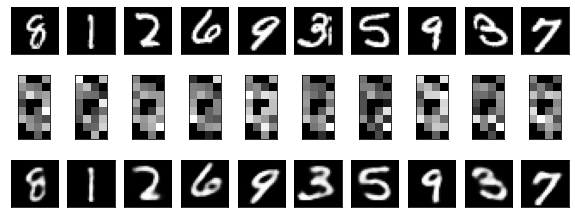

In [32]:
fig, axes = plt.subplots(3, num_images, figsize=(10,4))
for images, ax_row in zip([img_test, img_cod, img_dec], axes):
  for img,ax in zip(images, ax_row):
    ax.imshow(img,cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)